# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from substitutors import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
mouseline = 'sst' # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.DFF  # variable of interest for post-processing

### Derived parameters

In [4]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
# Construct dataset group ID
dataset_group_id = mouseline
if layer is not None:
    dataset_group_id = f'{dataset_group_id}_{layer}'
# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')
# Get figures PDF suffix
figs_suffix = f'{dataset_group_id}_k{kalman_gain}_{postpro_id}'
# Get trial-averaged input data directory
submap = [(1, 0), (FrameIndex.STIM - 1, FrameIndex.STIM)]
ss = StackSubstitutor(submap, repeat_every=NFRAMES_PER_TRIAL)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, baseline_id, kd.code, ss.code, mouseline)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 03/10/2022 16:57:24: sst batch notebook started on 2022-10-03 at 16:57:24


### Input summary table figure

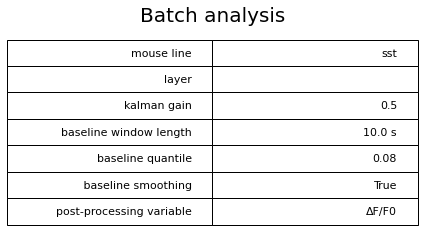

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Batch analysis')

## Input data

### Load data

In [11]:
# Determine exclude pattenrs
if mouseline == 'sst':
    exclude_patterns = SST_OFFSET_DATASETS
elif mouseline == 'line3':
    exclude_patterns = LINE3_SARAH_DATASETS
else:
    exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)

 03/10/2022 17:04:38: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/sst:
 03/10/2022 17:04:38: excluding datasets with the following patterns:
 - 20190518_mouse6_region1
 - 20190518_mouse7_region1
 - 20190601_mouse2_region1
 - 20190601_mouse7_region1
 - 20190601_mouse8_region1
 03/10/2022 17:04:39: loading trial-averaged data from 20190628_mouse2_region1.h5
 03/10/2022 17:04:39: loading trial-averaged data from 20190629_mouse3_region1.h5
 03/10/2022 17:04:39: loading trial-averaged data from 20190701_mouse1_region1.h5
 03/10/2022 17:04:39: loading trial-averaged data from 20190706_mouse7_region1.h5
 03/10/2022 17:04:39: loading trial-averaged data from 20190808_mouse6_region1.h5
 03/10/2022 17:04:39: loading trial-averaged data from 20190808_mouse8_region1a.h5
 03/10/2022 17:04:39: loading trial-averaged data from 20190808_mouse8_region1b.h5
 03/10/2022 17:04:39: gathering dataset IDs...
 03/10/20

### Breakdown per mouse region, cell maps & filter out datasets

 03/10/2022 16:57:30: extracting timeseries and stats from data...
 03/10/2022 16:57:31: plotting cells map color-coded by response type...
 03/10/2022 16:57:31: extracting responses types per ROI...
 03/10/2022 16:57:31: plotting cells map color-coded by response type...
 03/10/2022 16:57:31: extracting responses types per ROI...
 03/10/2022 16:57:32: plotting cells map color-coded by response type...
 03/10/2022 16:57:32: extracting responses types per ROI...
 03/10/2022 16:57:33: plotting cells map color-coded by response type...
 03/10/2022 16:57:33: extracting responses types per ROI...
 03/10/2022 16:57:33: plotting cells map color-coded by response type...
 03/10/2022 16:57:33: extracting responses types per ROI...
 03/10/2022 16:57:35: plotting cells map color-coded by response type...
 03/10/2022 16:57:35: extracting responses types per ROI...
 03/10/2022 16:57:35: plotting cells map color-coded by response type...
 03/10/2022 16:57:35: extracting responses types per ROI...
 0

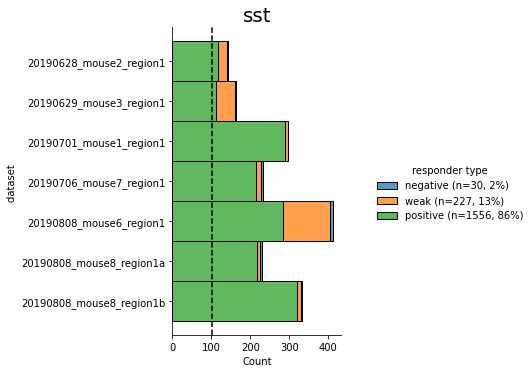

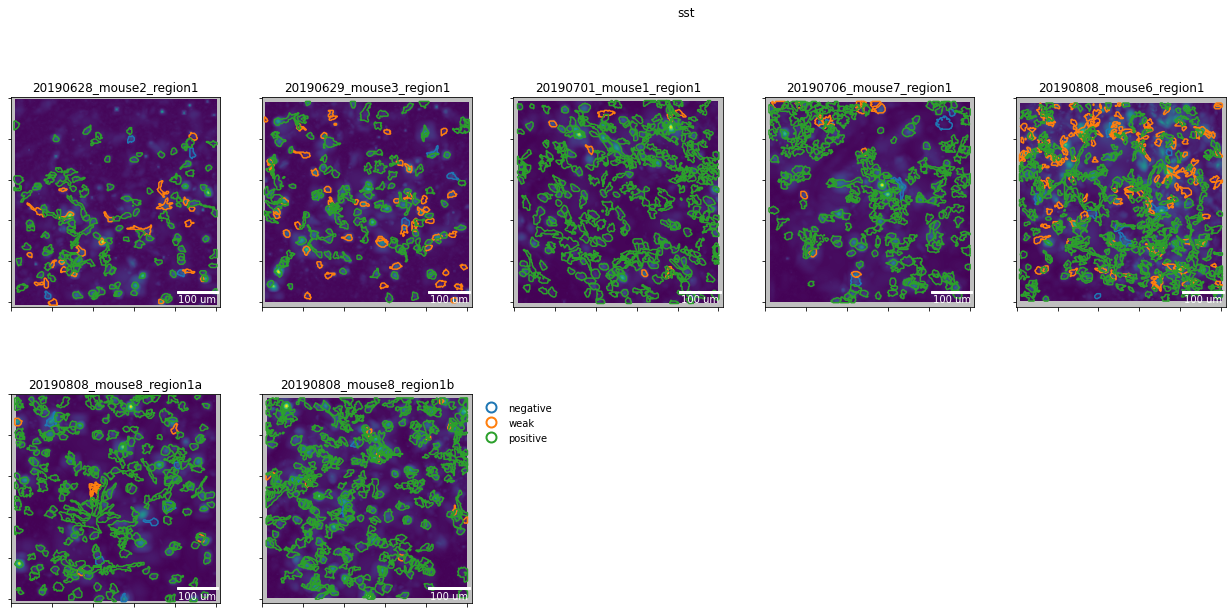

In [7]:
logger.info('extracting timeseries and stats from data...')
timeseries, stats, ROI_masks, map_ops = data['timeseries'], data['stats'], data['ROI_masks'], data['map_ops']

# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = int(np.round(MIN_CELL_DENSITY[mouseline] * area))

# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, countref=min_cell_count,
    title=mouseline)

figs['cellmaps'] = plot_cell_maps(
        ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

# Idendify datasets with a low overall cell count
logger.info(f'setting minimum cell count of {min_cell_count} as inclusion criterion')
cells = stats.groupby([Label.DATASET, Label.ROI]).first()
cellcounts = cells.groupby(Label.DATASET).count().iloc[:, 0].rename('cell count')
weaks = cells.loc[cells[Label.ROI_RESP_TYPE] == 'weak']
weakcounts = weaks.groupby(Label.DATASET).count().iloc[:, 0].rename('weak count')
pctresp = (1 - (weakcounts / cellcounts)) * 100
count_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()
count_exclude = []
# Manual exclusions
manual_exclude = {
    'line3': [], #'20191109_mouse7_region2'
    'sst': ['20190808_mouse6_region1'],
    'pv': []
}[mouseline]

# Exclude them
timeseries, stats = exclude_datasets(timeseries, stats, count_exclude + manual_exclude)

## Parameter dependency curves

### Plotting function

In [9]:
logger.info('defining plotting function...')

def plot_dep_curves(stats, ykey, title=None, detailed=True, weighted=False, **kwargs):
    logger.setLevel(logging.WARNING)
    # If detailed mode, one graph per response type
    suffix = '' if title is None else title
    if detailed:
        for pkey in [Label.P, Label.DC]:
            figs[f'{pkey}-dep {ykey}{suffix}'] = plot_parameter_dependency_across_datasets(
                stats, pkey, ykey, weighted=weighted, **kwargs)
            if title is not None:
                figs[f'{pkey}-dep {ykey}'].suptitle(title)
    # Otherwise, single graph with all response types
    else:
        # If weighted, aggregate for each dataset
        if weighted:
            df = stats.copy()
        else:
            df = resolve_columns(
                stats.groupby([Label.DATASET, Label.ROI_RESP_TYPE, Label.RUN]).mean(), 
                [Label.P, Label.DC])
        # Get keys for pre, post and change
        ykey_diff = get_change_key(ykey)
        figs[f'alldeps {ykey}{suffix}'] = plot_stimparams_dependency_per_response_type(
            df, ykey_diff, hue=Label.ROI_RESP_TYPE, yref=0, title=title, **kwargs)
    logger.setLevel(logging.INFO)

 21/09/2022 16:18:06: defining plotting function...


### With default parameters

 21/09/2022 16:18:36: plotting parameter dependencies
 21/09/2022 16:18:37: plotting detailed parameter dependencies


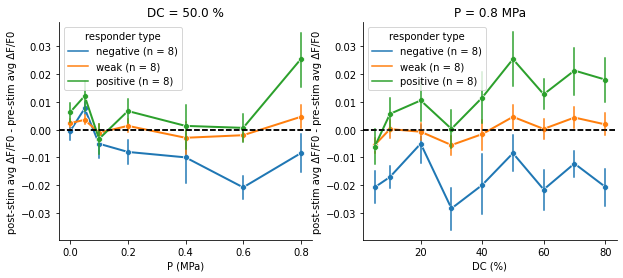

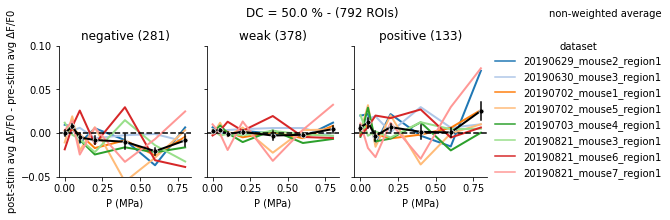

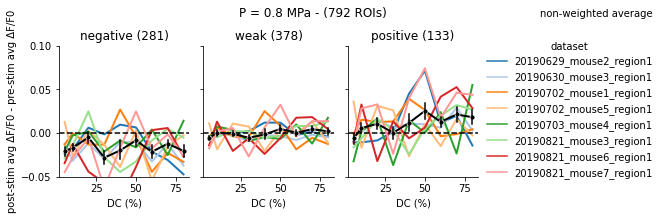

In [12]:
for detailed in [False, True]:
    logger.info(f'plotting {"detailed " if detailed else ""}parameter dependencies')
    plot_dep_curves(
        stats, ykey_postpro, detailed=detailed, err_style='bars')

### With ben's settings

In [13]:
# stats2 = classify(
#     timeseries, stats.copy(), ykey_postpro, 
#     wpre=slice(FrameIndex.STIM - 10, FrameIndex.STIM),
#     wpost=slice(FrameIndex.STIM + 1, FrameIndex.STIM + 11))
# plot_dep_curves(stats2, ykey_postpro, title=f'ben')

### Influence of threshold number of conditions 

In [14]:
# for n in [3, 5, 7]:
#     stats2 = classify_responders(stats.copy(), nposthr=n)
#     plot_dep_curves(stats2, ykey_postpro, title=f'nposthr = {n}', detailed=False)

### Influence of pre-stimulus anbd post-stimulus detection windows

In [15]:
# stats_vs_windows = {}
# for npre in [3, 7]:
#     for npost in [10, 20]:
#         stats_vs_windows[f'{npre}_{npost}'] = classify(
#             timeseries, stats.copy(), ykey_postpro, 
#             wpre=slice(FrameIndex.STIM - npre + 1, FrameIndex.STIM + 1),
#             wpost=slice(FrameIndex.STIM, FrameIndex.STIM + npost + 1))
#         plot_dep_curves(
#             stats_vs_windows[f'{npre}_{npost}'], ykey_postpro,
#             title=f'npre = {npre}, npost = {npost}')

## Response traces

### Get plot-ready traces dataset

In [16]:
plt_data = get_plot_data(timeseries, stats)

 21/09/2022 16:18:47: merging timeseries and stats information...
 21/09/2022 16:18:51: adding time info to table...


### Pressure-dependent response traces

 21/09/2022 16:18:52: plotting P (MPa) dependency curves for negative responders...
 21/09/2022 16:18:52: sub-indexing data...
 21/09/2022 16:18:52: filtering data...
 21/09/2022 16:18:52: cross-checking filters...
 21/09/2022 16:18:52: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 21/09/2022 16:18:54: plotting P (MPa) dependency curves for positive responders...
 21/09/2022 16:18:54: sub-indexing data...
 21/09/2022 16:18:54: filtering data...
 21/09/2022 16:18:54: cross-checking filters...
 21/09/2022 16:18:54: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 21/09/2022 16:18:55: plotting P (MPa) dependency curves for weak responders...
 21/09/2022 16:18:55: sub-indexing data...
 21/09/2022 16:18:55: filtering data...
 21/09/2022 16:18:55: cross-checking filters...
 21/09/2022 16:18:55: grouping by dataset, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...


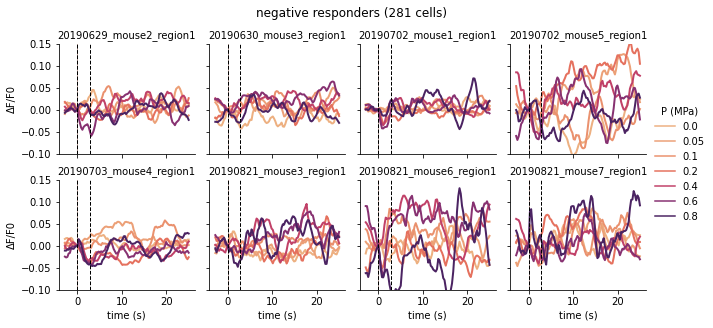

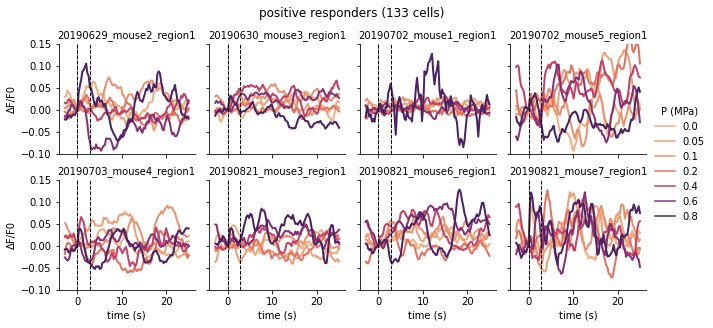

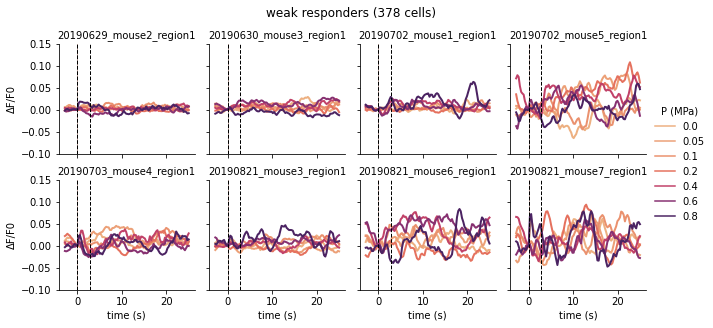

In [17]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.P))

### DC-dependent response traces

 21/09/2022 16:18:59: plotting DC (%) dependency curves for negative responders...
 21/09/2022 16:18:59: sub-indexing data...
 21/09/2022 16:18:59: filtering data...
 21/09/2022 16:18:59: cross-checking filters...
 21/09/2022 16:18:59: grouping by dataset, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 21/09/2022 16:19:02: plotting DC (%) dependency curves for positive responders...
 21/09/2022 16:19:02: sub-indexing data...
 21/09/2022 16:19:02: filtering data...
 21/09/2022 16:19:02: cross-checking filters...
 21/09/2022 16:19:02: grouping by dataset, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 21/09/2022 16:19:03: plotting DC (%) dependency curves for weak responders...
 21/09/2022 16:19:03: sub-indexing data...
 21/09/2022 16:19:03: filtering data...
 21/09/2022 16:19:03: cross-checking filters...
 21/09/2022 16:19:03: grouping by dataset, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...


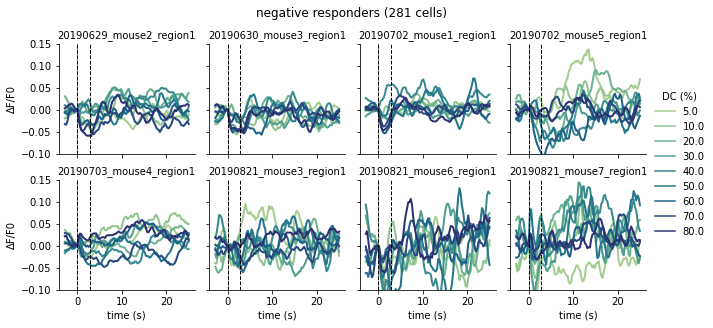

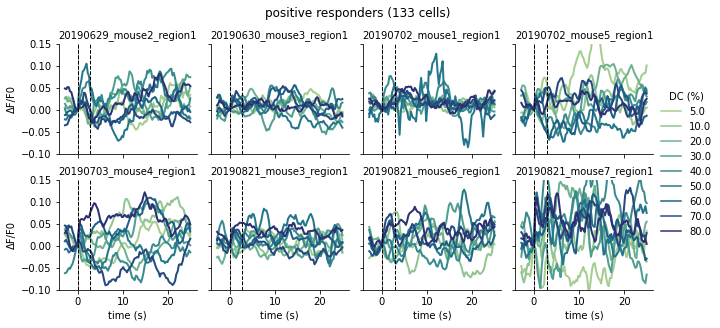

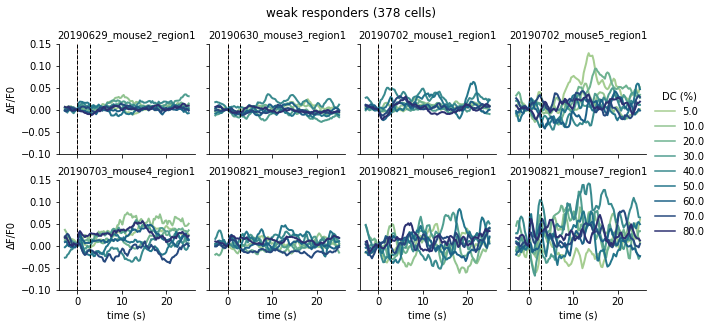

In [18]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.DC))

### Average response traces across datasets (weighted)

 21/09/2022 16:19:07: sub-indexing data...
 21/09/2022 16:19:07: filtering data...
 21/09/2022 16:19:08: cross-checking filters...
 21/09/2022 16:19:08: grouping by responder type, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 21/09/2022 16:19:11: sub-indexing data...
 21/09/2022 16:19:11: filtering data...
 21/09/2022 16:19:11: cross-checking filters...
 21/09/2022 16:19:11: grouping by responder type, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...


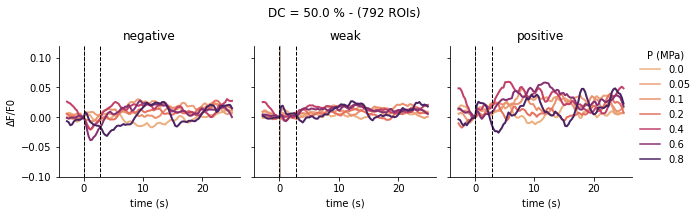

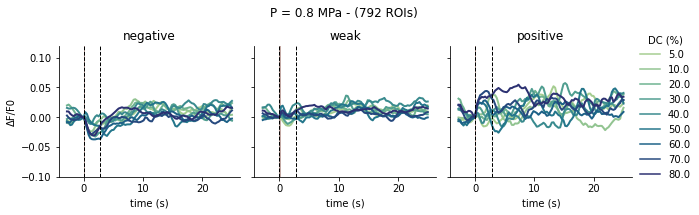

In [19]:
# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - weighted'] = plot_responses_across_datasets(
        plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Average response traces across datasets (non-weighted)

 21/09/2022 16:19:15: checking for run order consistency across datasets...
 21/09/2022 16:19:16: computing average traces per dataset and condition...
 21/09/2022 16:19:17: sub-indexing data...
 21/09/2022 16:19:17: filtering data...
 21/09/2022 16:19:17: cross-checking filters...
 21/09/2022 16:19:17: grouping by responder type, grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 21/09/2022 16:19:17: sub-indexing data...
 21/09/2022 16:19:17: filtering data...
 21/09/2022 16:19:17: cross-checking filters...
 21/09/2022 16:19:17: grouping by responder type, grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...


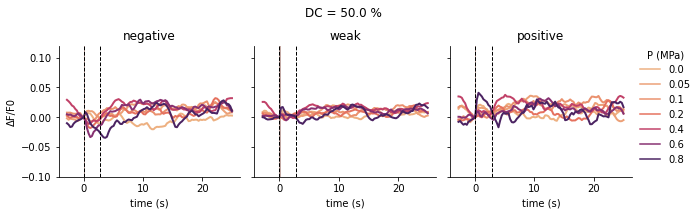

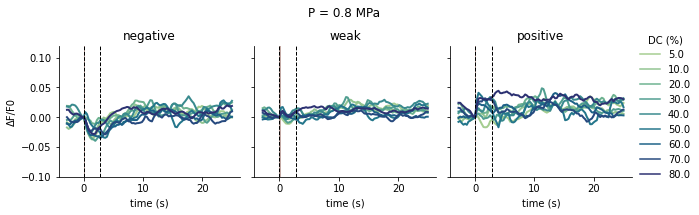

In [20]:
# Check run order consistency across datasets
logger.info('checking for run order consistency across datasets...')
params_per_run = plt_data.groupby([Label.DATASET, Label.RUN]).first()[[Label.P, Label.DC]]
for k in params_per_run:
    sum_of_stds = params_per_run[k].unstack().std().sum()
    if sum_of_stds > 1e-12:
        logger.error('variation in run orders across dataset')

# Group data by mouse-region, response type, run and frame -> average
logger.info('computing average traces per dataset and condition...')
avg_plt_data = plt_data.groupby(
    [Label.DATASET, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR, Label.TIME])

# Plot response curves for both input stimulation parameters
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - nonweighted'] = plot_responses_across_datasets(
        avg_plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Save figures

In [21]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 21/09/2022 16:19:17: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.09.21/figs_pv_k0.5_w10.0s_q0.08_smooth_ΔFF0.pdf:


100%|██████████| 16/16 [00:03<00:00,  4.82it/s]


### Notify upon completion

In [22]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 21/09/2022 16:19:21: pv batch notebook completed in 0:03:42.858391 s
